In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; float:center}</style>")

In [105]:
from __future__ import division, print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score




%matplotlib inline



sns.set_context('talk', font_scale=1.5)
sns.set_style('ticks', {'font.family': [u'sans-serif']})

subs = ['had trouble','had issue','exchange','recommend','change','easier','gluten free','gluten-free','vegan','vegetarian','easier','replace with','replac','adjust','suggest','swap','switch','instead of','in place of','substitute','replace','i use','to make it','customiz','adjust','instead','exchang','opted to use','better with']
add = ['will ad','will do','next time','going to add','add more','better with','includ','i up','should have ad']
omit = ['omit','leave out','remov','left out','eliminat','add less','forgot','decreas','dispensed with','delet','reduc','should have left out']

punctuation = ['.',',',':','!',';','-','?','"',"'",'(',')','—']   
other = ['ive','ve', "i've", "i'v", 'i’ll', 'i’ve', 'i’v']  # 'deb','hideb','don','didn','twaittry','doesn','thank','heydeb',
mystops = stopwords.words('english') + punctuation + other + subs + add + omit


import & sanity check

In [123]:
comments = pd.read_csv('/Users/kateliea/Documents/Insight/project/algorithm/training_data.csv',index_col=0)
# comments = comments.dropna(how='any')

comments = comments.dropna()

# comments['category_simple'] = comments.category
# comments['category_simple'] = comments.category_simple.replace(['addition','substitution','omission'],'helpful')

# comments.category_simple.unique()

In [124]:
comments.columns

Index(['sentence', 'commentID', 'child_id', 'children', 'comment_time',
       'recipenumber', 'title', 'url', 'usercomment', 'username', 'usersite',
       'usercomment_lower', 'tokens', 'tokens_stemmed', 'sentence_tokens',
       'sentence_tokens_stemmed_stops', 'sentence_tokens_stemmed', 'category',
       'category_simple', 'sent_neg', 'sent_neu', 'sent_pos', 'sent_compound'],
      dtype='object')

In [5]:
X_sent = comments[['sent_neg', 'sent_neu', 'sent_pos', 'sent_compound']]
X_sent.as_matrix()

array([[ 0.    ,  0.687 ,  0.313 ,  0.7121],
       [ 0.    ,  0.    ,  1.    ,  0.6476],
       [ 0.357 ,  0.643 ,  0.    , -0.416 ],
       ..., 
       [ 0.    ,  0.    ,  1.    ,  0.4926],
       [ 0.    ,  0.526 ,  0.474 ,  0.4019],
       [ 0.    ,  0.806 ,  0.194 ,  0.6239]])

# pipeline - identify 'helpful' vs 'other' comments

### define data sets

In [125]:
X = comments.sentence_tokens_stemmed
Y = comments.category_simple


X_sent = comments[['sent_neg', 'sent_neu', 'sent_pos', 'sent_compound']]

num_folds = 10
num_instances = len(X)
seed = 42

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)



# split = 20000
# X_train = comments.sentence_tokens_stemmed[:split] #\.as_matrix()
# target_train = comments.category_simple[:split] #.as_matrix()
# target_train.replace(['addition','substitution','omission'],'helpful',inplace=True)


# X_test = comments.sentence_tokens_stemmed[split:]
# target_test = comments.category_simple[split:]
# target_test.replace(['addition','substitution','omission'],'helpful',inplace=True)

split = 20000
X_train = comments.sentence[:split] #\.as_matrix()
target_train = comments.category_simple[:split] #.as_matrix()
target_train.replace(['addition','substitution','omission'],'helpful',inplace=True)


X_test = comments.sentence[split:]
target_test = comments.category_simple[split:]
target_test.replace(['addition','substitution','omission'],'helpful',inplace=True)

test_all = comments[split:]

# encode classes labels as ints
target_test_bin = LabelEncoder().fit_transform(target_test)
# list(labelencoder.classes_)

len(X_test), len(target_test)

print('total comments that should be helpful, %i' % test_all[test_all.category_simple == 'helpful'].category.count())
print('total comments that should be other, %i' % test_all[test_all.category_simple == 'other'].category.count())

total comments that should be helpful, 4179
total comments that should be other, 70432


## Naive Bayes classifier

In [126]:
classifier_helpful_NB = Pipeline([('vectorizer', CountVectorizer(ngram_range=(2,6), max_df=1000000, min_df=3)),
                                  ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
                                  ('classifier', MultinomialNB(alpha=1.0, class_prior=[0.1,0.9], fit_prior=True))])


# classifier_helpful_NB = Pipeline([('vectorizer', CountVectorizer(ngram_range=(2,6), stop_words=mystops, max_df=1000000, min_df=3)),
#                                   ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
#                                   ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

classifier_helpful_NB.fit(X_train, target_train) 
predicted_NB = classifier_helpful_NB.predict(X_test) 
confmatrix_NB = confusion_matrix(target_test, predicted_NB)
probs_NB = classifier_helpful_NB.predict_proba(X_test)

predicted_NB_bin = LabelEncoder().fit_transform(predicted_NB)
falsepos_NB, truepos_NB, _ = sklearn.metrics.roc_curve(target_test_bin, probs_NB[:,1]) # 2nd column is positive class


print('accuracy, %0.4f' % np.mean(predicted_NB == target_test))
print('score, %0.4f' % classifier_helpful_NB.score(X_test,target_test))
print('confusion matrix', confmatrix_NB)
print('correctly classified helpful %i' % test_all[(test_all.category_simple == predicted_NB) & (test_all.category_simple == 'helpful' )].shape[0])
print('prob/recall/F1', precision_recall_fscore_support(target_test_bin, predicted_NB_bin))

accuracy, 0.9500
score, 0.9500
confusion matrix [[  459  3720]
 [   12 70420]]
correctly classified helpful 459
prob/recall/F1 (array([ 0.97452229,  0.94982466]), array([ 0.10983489,  0.99982962]), array([ 0.19741935,  0.97418587]), array([ 4179, 70432]))


In [ ]:
results_NB = cross_val_score(classifier_helpful_NB, X, Y, cv=kfold)
print(results_NB.mean())

## stochastic gradient descent classifier (logarithmic)

accuracy, 0.9140
score, 0.9140
confusion matrix [[ 2865  1314]
 [ 5100 65332]]
correctly classified helpful 2865
(array([ 0.35969868,  0.98028389]), array([ 0.68557071,  0.92758973]), array([ 0.47183794,  0.95320912]), array([ 4179, 70432]))


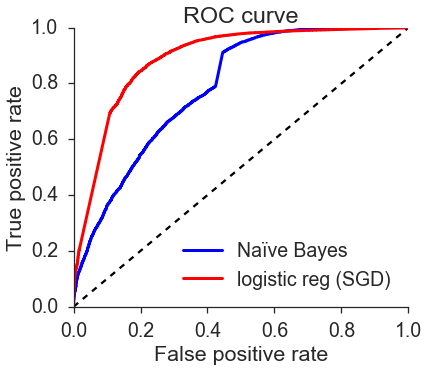

In [127]:
classifier_helpful_SGD = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,10), stop_words=mystops, max_df=1000000, min_df=5)),
                                   ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
                                   ('classifier', SGDClassifier(alpha=0.0005, average=False, class_weight={'helpful':8.5, 'other':0.7}, epsilon=0.1,
                                eta0=0, fit_intercept=True, l1_ratio=0, learning_rate='optimal', loss='log', n_iter=50, n_jobs=1,
                                penalty='l1', power_t=0.5, random_state=42, shuffle=True))])

classifier_helpful_SGD = classifier_helpful_SGD.fit(X_train, target_train)
predicted_SGD = classifier_helpful_SGD.predict(X_test)
confmatrix_SGD = confusion_matrix(target_test, predicted_SGD)
probs_SGD = classifier_helpful_SGD.predict_proba(X_test)

predicted_SGD_bin = LabelEncoder().fit_transform(predicted_SGD)
falsepos_SGD, truepos_SGD, _ = sklearn.metrics.roc_curve(target_test_bin, probs_SGD[:,1]) # 2nd column is positive class


print('accuracy, %0.4f' % np.mean(predicted_SGD == target_test))
print('score, %0.4f' % classifier_helpful_SGD.score(X_test,target_test))
print('confusion matrix', confmatrix_SGD)
print('correctly classified helpful %i' % test_all[(test_all.category_simple == predicted_SGD) & (test_all.category_simple == 'helpful' )].shape[0])
# print('prob/recall/F1', precision_recall_fscore_support(target_test_bin, predicted_SGD_bin))
print(precision_recall_fscore_support(target_test_bin, predicted_SGD_bin))


lw = 3
fig, ax = plt.subplots(figsize=(6,5))
ax.plot([0,1],[0,1],'k--')
ax.plot(falsepos_NB, truepos_NB, 'b', label='Naïve Bayes', linewidth=lw)
ax.plot(falsepos_SGD, truepos_SGD, 'r', label='logistic reg (SGD)', linewidth=lw)

ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
sns.despine()

plt.savefig('ROC_curve.jpg')

save classifier for web app 

In [55]:
from sklearn.externals import joblib
joblib.dump(classifier_helpful_SGD, 'commentsclassifier.pkl') 

['commentsclassifier.pkl',
 'commentsclassifier.pkl_01.npy',
 'commentsclassifier.pkl_02.npy',
 'commentsclassifier.pkl_03.npy',
 'commentsclassifier.pkl_04.npy',
 'commentsclassifier.pkl_05.npy',
 'commentsclassifier.pkl_06.npy']

## check that things aren't just random

In [90]:
from random import shuffle

In [78]:
random = target_test.reset_index()['category_simple']
random[random=='helpful'].count()
len(random)

74611

In [92]:
random = []
random = ['other']*69157 + ['helpful']*5454
shuffle(random)


accuracy, 0.8245
score, 0.8245
confusion matrix [[  655  4799]
 [ 8293 60864]]
(array([ 0.07320072,  0.9269147 ]), array([ 0.12009534,  0.88008445]), array([ 0.09095959,  0.90289275]), array([ 5454, 69157]))


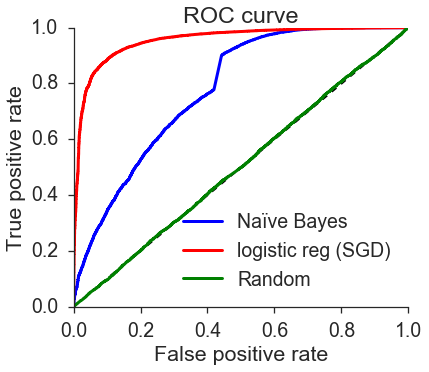

In [97]:
falsepos_rand, truepos_rand, _ = sklearn.metrics.roc_curve(LabelEncoder().fit_transform(random), probs_SGD[:,1]) # 2nd column is positive class
confmatrix_SGD = confusion_matrix(random, predicted_SGD)


print('accuracy, %0.4f' % np.mean(predicted_SGD == random))
print('score, %0.4f' % classifier_helpful_SGD.score(X_test,random))
print('confusion matrix', confmatrix_SGD)
# print('correctly classified helpful %i' % test_all[(test_all.category_simple == predicted_SGD) & (test_all.category_simple == 'helpful' )].shape[0])
# print('prob/recall/F1', precision_recall_fscore_support(target_test_bin, predicted_SGD_bin))
print(precision_recall_fscore_support(LabelEncoder().fit_transform(random), predicted_SGD_bin))



lw = 3
fig, ax = plt.subplots(figsize=(6,5))
ax.plot([0,1],[0,1],'k--')
ax.plot(falsepos_NB, truepos_NB, 'b', label='Naïve Bayes', linewidth=lw)
ax.plot(falsepos_SGD, truepos_SGD, 'r', label='logistic reg (SGD)', linewidth=lw)
ax.plot(falsepos_rand, truepos_rand, 'g', label='Random', linewidth=lw)


ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
sns.despine()



### monkeying around with adding sentiment

In [41]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin


class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

In [42]:
list(NLTKPreprocessor().lemmatize('tramp', 'N'))

['t', 'r', 'a', 'm', 'p']

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin
import string


class AnalyzeSentiment(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = mystops
        self.punct      = punct or set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return self
    
#     def tokenize(self,doc):
#         for sent in doc: 
#             yield self.sent_value(sent)

    def sent_value(self, docs):    
        features = np.recarray(shape=(len(docs),1),
                               dtype=[('sentiment', object)])
        
        
        for i, text in enumerate(docs):
            sentiment = SentimentIntensityAnalyzer().polarity_scores(text)
            features[i]['sentiment'] = sentiment
            
        return features

#         return features
# #         sentiment = SentimentIntensityAnalyzer().polarity_scores(sent).values()
#         return [{'compound':SentimentIntensityAnalyzer().polarity_scores(sent)['compound'],
#                 'negative':SentimentIntensityAnalyzer().polarity_scores(sent)['neg'], 
#                 'neutral':SentimentIntensityAnalyzer().polarity_scores(sent)['neu'], 
#                 'positive':SentimentIntensityAnalyzer().polarity_scores(sent)['pos']}
#                for sent in doc]
# #         SentimentIntensityAnalyzer().polarity_scores(mysentence).values()

In [44]:
li = SentimentIntensityAnalyzer().polarity_scores(mysentence)
li['compound']

# li = np.array(list(li))[-1]
# li

NameError: name 'mysentence' is not defined

In [45]:
list(AnalyzeSentiment().sent_value(X_train[:10]))

[rec.array([({'compound': 0.7121, 'pos': 0.313, 'neu': 0.687, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.6476, 'pos': 1.0, 'neu': 0.0, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': -0.416, 'pos': 0.0, 'neu': 0.643, 'neg': 0.357},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.7959, 'pos': 0.587, 'neu': 0.413, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.4019, 'pos': 0.252, 'neu': 0.748, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.5093, 'pos': 0.148, 'neu': 0.852, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.6996, 'pos': 0.234, 'neu': 0.766, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.0, 'pos': 0.0, 'neu': 1.0, 'neg': 0.0},)], 
           dtype=[('sentiment', 'O')]),
 rec.array([({'compound': 0.6705, 'pos': 0.44, 'neu': 0.56,

In [46]:
mysentence = 'this is a test of greatest proportions'

In [47]:
wordpipe = Pipeline([('vectorizer', CountVectorizer(ngram_range=(2,6), max_df=1000000, min_df=3)),
                                  ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

sentpipe = AnalyzeSentiment()

In [48]:
features = FeatureUnion([('words', wordpipe), ('sentiment', sentpipe)])

In [49]:
testpipe = Pipeline([('features', features), ('classifier',MultinomialNB(alpha=1.0, class_prior=[0.1,0.9], fit_prior=True))])

In [50]:
features.fit(X_test[:100], target_test[:100])

FeatureUnion(n_jobs=1,
       transformer_list=[('words', Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1000000, max_features=None, min_df=3,
        ngram_range=(2, 6), pr... '"', "'", '(', ')', '—', 'ive', 've', "i've", "i'v", 'i’ll', 'i’ve', 'i’v'],
         strip=True))],
       transformer_weights=None)

In [51]:
testpipe = Pipeline([('features', FeatureUnion([('words', wordpipe), ('sentiment', sentpipe)])), 
                     ('classifier',MultinomialNB(alpha=1.0, class_prior=[0.1,0.9], fit_prior=True))])

In [ ]:
CountVectorizer(ngram_range=(2,6), max_df=1000000, min_df=3).fit(X_train)

# pipeline - identify 'substitute' vs 'add/omit' versus comments 

In [ ]:
classifier_helpful_SGD = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,6), stop_words=mystops, max_df=1000000, min_df=5)),
                                   ('transformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
                                   ('classifier', SGDClassifier(alpha=0.0005, average=False, class_weight={'helpful':8.5, 'other':0.7}, epsilon=0.1,
                                eta0=0, fit_intercept=True, l1_ratio=0, learning_rate='optimal', loss='log', n_iter=100, n_jobs=1,
                                penalty='l2', power_t=0.5, random_state=42, shuffle=True))])



In [99]:
vectorizer = CountVectorizer(ngram_range=(1,6), stop_words=mystops, max_df=1000000, min_df=5)
transformer = TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)
classifier = SGDClassifier(alpha=0.0005, average=False, class_weight={'helpful':8.5, 'other':0.7}, epsilon=0.1,
                                eta0=0, fit_intercept=True, l1_ratio=0, learning_rate='optimal', loss='log', n_iter=100, n_jobs=1,
                                penalty='l2', power_t=0.5, random_state=42, shuffle=True)


X_train_counts = vectorizer.fit_transform(X_train)
print(X_train_counts.shape)

# transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train_tf = transformer.fit_transform(X_train_counts)
print(X_train_tf.shape)




X_test_counts = vectorizer.fit_transform(X_test)
print(X_test_counts.shape)

# transformer = TfidfTransformer(use_idf=False).fit(X_test_counts)

X_test_tf = transformer.fit_transform(X_test_counts)
print(X_test_tf.shape)


(20000, 4873)
(20000, 4873)
(74611, 15819)
(74611, 15819)


In [100]:
type(X_test_tf)

scipy.sparse.csr.csr_matrix

In [101]:
from scipy.sparse import hstack

In [102]:
all_train = hstack((X_train_tf, X_sent[:split]))
all_test = hstack((X_test_tf, X_sent[split:]))

In [103]:
fit = classifier.fit(all_train, target_train)

In [104]:
predict = classifier.predict(all_test)

ValueError: X has 15823 features per sample; expecting 4877

In [38]:
all_test.shape

(74611, 15818)